In [24]:
from typing import Annotated
import base64
import os
from typing_extensions import TypedDict
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import io
import numpy as np


os.environ["NVIDIA_API_KEY"] = ""


In [25]:

llm = ChatNVIDIA(model="microsoft/phi-3-vision-128k-instruct")

def chat_with_nim(text:str,image_base64:str|None=None)->str:
    prompt = text
    if image_base64 is not None:
        prompt += f'<img src="data:image/png;base64,{image_base64}" />'
        
    
    response = llm.invoke(prompt)
    return str(response.content)

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: str | None
    data: pd.DataFrame

def plt_to_base64()->str:
    figfile = io.BytesIO()
    plt.savefig(figfile, format='png')
    figfile.seek(0)  # rewind to beginning of file
    figdata_png = base64.b64encode(figfile.getvalue())
    return figdata_png.decode('utf8')

graph_builder = StateGraph(State)

In [26]:
def is_const_var(state: State):
    state["data"].plot.scatter(x="X", y="Y")
    
    b64 = plt_to_base64()
    
    prompt = "You are a data analysis expert. Does this set of data have constant variance? You only need to answer True or False."
    return {"messages": chat_with_nim(prompt, b64)}

def is_normal(state: State):
    data = state["data"]
    fit = sm.OLS(data["Y"], sm.add_constant(data["X"])).fit()
    resid = fit.resid
    
    sm.qqplot(resid, line='s')
    b64 = plt_to_base64()
    
    prompt = "You are a data analysis expert. The attached figure is the Q-Q plot of this set of data. Does this set of data conform to the normal hypothesis? You only need to answer True or False."
    return {"messages": chat_with_nim(prompt, b64), "resid": resid}

def lse(state: State):
    data = state["data"]
    fit = sm.OLS(data["Y"], sm.add_constant(data["X"])).fit()
    return {"messages": str(fit.summary())}

def not_implemented(state: State):
    raise NotImplementedError

graph_builder.add_node("is_const_var", is_const_var)
graph_builder.add_node("normal_no_const", is_normal)
graph_builder.add_node("normal_has_const", is_normal)
graph_builder.add_node("lse", lse)
graph_builder.add_node("not_implemented", not_implemented)

In [27]:
def m1(data: pd.DataFrame, resid: pd.Series):
    fit = sm.OLS(resid.abs(), sm.add_constant(data["X"])).fit()
    return fit.predict()


def m2(data: pd.DataFrame, resid: pd.Series):
    fit = sm.OLS(resid.abs(), sm.add_constant(data["Y"])).fit()
    return fit.predict()


def m3(data: pd.DataFrame, resid: pd.Series):
    fit = sm.OLS(resid**2, sm.add_constant(data["X"])).fit()
    return fit.predict().sqrt()


def m4(data: pd.DataFrame, resid: pd.Series):
    raise NotImplementedError


def weight(input: str, data: pd.DataFrame, resid: pd.Series) -> pd.Series:
    branch = input.strip()
    if not branch.isdigit():
        raise ValueError("Branch must be a number")
    branch = int(branch)
    if branch == 1:
        return 1 / m1(data, resid) ** 2
    elif branch == 2:
        return 1 / m2(data, resid) ** 2
    elif branch == 3:
        return 1 / m3(data, resid) ** 2
    elif branch == 4:
        return 1 / m4(data, resid) ** 2
    else:
        raise ValueError("Branch must be between 1 and 4")

def judge_weight(data: pd.DataFrame, resid: pd.Series):
    fig, ax = plt.subplots( nrows=3, ncols=1 , figsize=(10,10), squeeze=False)
    ax[0,0].plot(data['X'],resid , 'o')
    ax[0,0].set_ylabel('Residuals')
    ax[0,0].set_xlabel('X')
    ax[1,0].plot(data['Y'],resid , 'o')
    ax[1,0].set_ylabel('Residuals')
    ax[1,0].set_xlabel('Y')
    ax[2,0].plot(data['X'],resid**2 , 'o')
    ax[2,0].set_ylabel('Residuals^2')
    ax[2,0].set_xlabel('X')
    
    b64 = plt_to_base64()
    
    prompt = f"""
    You are a data analysis expert. The pictures from top to bottom are
1. e & X
2. e & Y
3. e^2 & X
Point diagram

The picture shows which of the following relationships this set of data meets:
1. e and X are from concentrated to dispersed
2. e and Y are from concentrated to dispersed
3. e^2 and X are in an upward trend
4. The rate of change of e and X is from large to small
You only need to answer the number. If there are multiple conditions that meet the conditions, only answer the one with the smallest number.
    """
    return chat_with_nim(prompt, b64)

def wlse(state:State):
    
    data = state["data"]
    fit = sm.OLS(data["Y"], sm.add_constant(data["X"])).fit()
    resid = fit.resid
    judge = judge_weight(data, resid)
    w = weight(judge, data, resid)
    fit = sm.WLS(data["Y"], sm.add_constant(data["X"]), weights=w).fit()  # type: ignore
    return {"messages": str(fit.summary())}

graph_builder.add_node("wlse", wlse)

In [28]:
def t1(data: pd.DataFrame):
    return np.log(data["Y"])
def t2(data: pd.DataFrame):
    return np.sqrt(data["Y"])

def judge_transformation(data: pd.DataFrame):
    Y_sort = data['Y'].sort_values().to_numpy()
    group_n = int(len(Y_sort)**(0.5))+1
    groups = np.array_split(Y_sort, group_n)
    y_means = [np.mean(group) for group in groups]
    y_vars = [np.var(group) for group in groups]
    plt.plot(y_means, y_vars)
    
    b64 = plt_to_base64()
    
    prompt = rf"""
    You are a data analyst. You are doing regression analysis. The attached figure is a graph of E[Y] and Var[Y]. This shows that \sigma(\theta) is related to one of the following:
    1. k*\theta
    2. k*\sqrt(\theta)
    You only need to answer the sequence number. If there are multiple possibilities, only answer the one with the smallest number.
    """
    return chat_with_nim(prompt, b64)

def t(input:str, data: pd.DataFrame):
    branch = input.strip()
    if not branch.isdigit():
        raise ValueError("Branch must be a number")
    branch = int(branch)
    if branch == 1:
        return t1(data)
    elif branch == 2:
        return t2(data)
    else:
        raise ValueError("Branch must be between 1 and 2")

def transformation(state:State):
    data = state["data"]
    judge = judge_transformation(data)
    data["Y"] = t(judge, data)
    return {"data": data}

graph_builder.add_node("transformation", transformation)

In [29]:
graph_builder.add_edge(START, "is_const_var")
graph_builder.add_edge("wlse", END)
graph_builder.add_edge("lse", END)
graph_builder.add_edge("transformation", "is_const_var")

In [30]:
def route_is_const_var(state: State):
    resp = state["messages"]
    if resp is None:
        raise ValueError("invalid response")
    match resp.lower():
        case "true":
            return "yes"
        case "false":
            return "no"
        case _:
            raise ValueError("invalid response")
        
def route_is_normal(state: State):
    resp = state["messages"]
    if resp is None:
        raise ValueError("invalid response")
    match resp.lower():
        case "true":
            return "is_normal"
        case "false":
            return "not_normal"
        case _:
            raise ValueError("invalid response")

graph_builder.add_conditional_edges("is_const_var", route_is_const_var, {"yes": "normal_has_const", "no": "normal_no_const"})
graph_builder.add_conditional_edges("normal_no_const", route_is_normal, {"is_normal": "wlse", "no": "transformation"})
graph_builder.add_conditional_edges("normal_has_const", route_is_normal, {"is_normal": "lse", "no": "not_implemented"})

In [31]:
def preprocess(data: pd.DataFrame):
    return {"data": data}

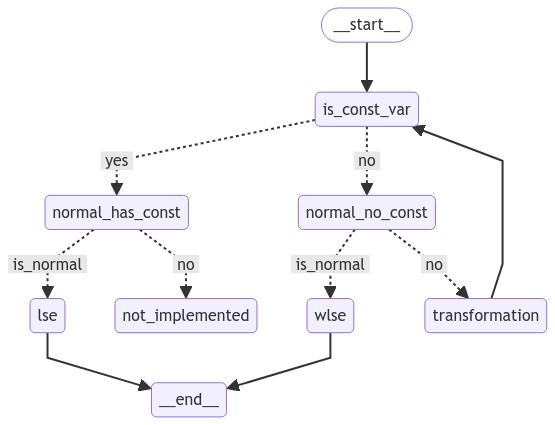

In [32]:

from IPython.display import Image, display
graph = graph_builder.compile()
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

C:\Users\chenj\AppData\Local\Temp\ipykernel_6236\1849466681.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_table("data.txt", sep="  ",header=None)


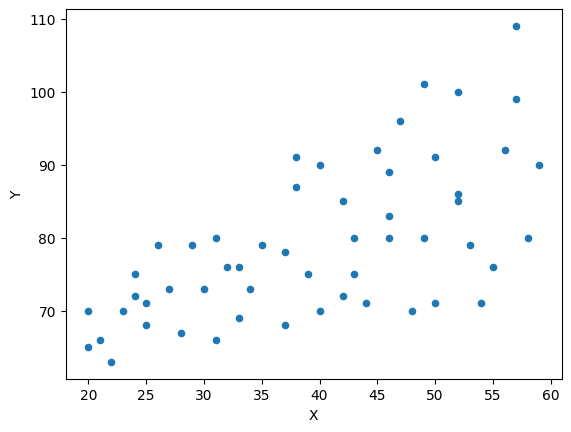

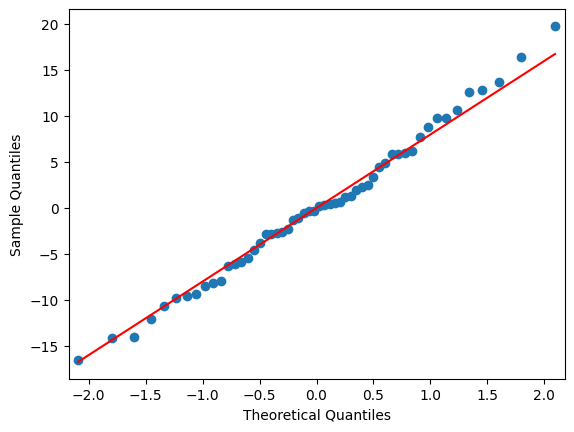

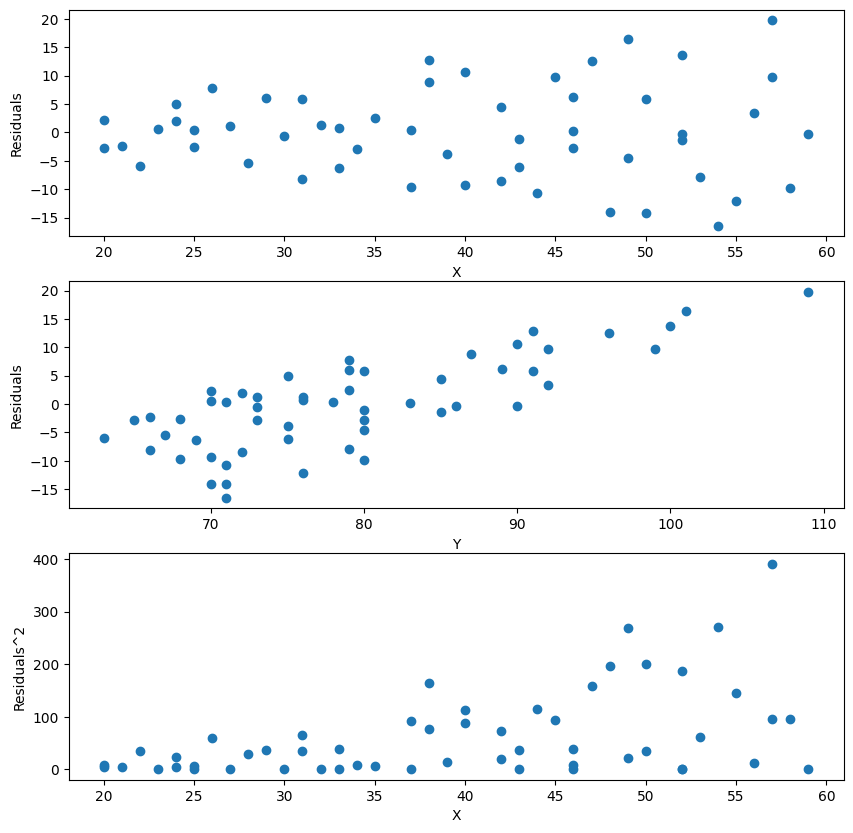

In [33]:
data = pd.read_table("data.txt", sep="  ",header=None)
data.columns = ["X", "Y"]

resp = graph.invoke({"data": data})

In [34]:
print(resp["messages"])

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.521
Model:                            WLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     56.64
Date:                Sun, 21 Jul 2024   Prob (F-statistic):           7.19e-10
Time:                        00:24:18   Log-Likelihood:                -181.26
No. Observations:                  54   AIC:                             366.5
Df Residuals:                      52   BIC:                             370.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.5658      2.521     22.042      0.0